For deep learning purposes, I will use transfer learning to train the model. For this, I will use the BERT model. The methods I used are:
- Data Loading and Preprocessing
- Tokenization
- Model Loading and Configuration
- Training
- Evaluation
- Save Model
- Inference

### Load Dataset

In [ ]:
import pandas as pd

In [ ]:
# load the dataset
df_train = pd.read_csv("/content/data/train_data.csv")
df_test = pd.read_csv("/content/data/test_data.csv")

In [ ]:
# adding columns name
df_train.columns = ["review", "target"]
df_test.columns = ["review", "target"]

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  25000 non-null  object
 1   target  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [ ]:
df_train.describe()

,target
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [ ]:
# Remove duplicates
df_train.drop_duplicates(inplace = True)
df_test.drop_duplicates(inplace = True)

In [ ]:
df_train.head()

,review,target
0,"This film is absolutely awful, but nevertheles...",0
1,Well since seeing part's 1 through 3 I can hon...,0
2,I got to see this film at a preview and was da...,1
3,This adaptation positively butchers a classic ...,0
4,Råzone is an awful movie! It is so simple. It ...,0


### Tokenization

In [ ]:
from transformers import AutoTokenizer

In [ ]:
# Define model checkpoint to use for tokenization
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

df_test, df_val = train_test_split(df_test, test_size = 0.5, stratify = df_test["target"])

In [ ]:
# Display shapes
df_test.shape, df_val.shape

((12400, 2), (12401, 2))

In [ ]:
from datasets import Dataset, DatasetDict
# Create DatasestDict from dataframe. (Purpose compatibility)
dataset = DatasetDict(
    {
        "train" : Dataset.from_pandas(df_train, preserve_index=False),
        "test" : Dataset.from_pandas(df_test, preserve_index=False),
        "val" : Dataset.from_pandas(df_val, preserve_index=False)
    }
)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'target'],
        num_rows: 24904
    })
    test: Dataset({
        features: ['review', 'target'],
        num_rows: 12400
    })
    val: Dataset({
        features: ['review', 'target'],
        num_rows: 12401
    })
})

In [ ]:
# tokenizer function
def tokenize_fun(batch):
    temp = tokenizer(batch["review"], padding = True, truncation = True)
    return temp

In [ ]:
# Apply Tokenization
review_encoded = dataset.map(tokenize_fun, batched = True, batch_size = None)

Map:   0%|          | 0/24904 [00:00<?, ? examples/s]

Map:   0%|          | 0/12400 [00:00<?, ? examples/s]

Map:   0%|          | 0/12401 [00:00<?, ? examples/s]

In [ ]:
review_encoded

DatasetDict({
    train: Dataset({
        features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 24904
    })
    test: Dataset({
        features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12400
    })
    val: Dataset({
        features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12401
    })
})

In [ ]:
# Rename target column to labels
review_encoded = review_encoded.rename_column("target", "labels")

In [ ]:
review_encoded

DatasetDict({
    train: Dataset({
        features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 24904
    })
    test: Dataset({
        features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12400
    })
    val: Dataset({
        features: ['review', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 12401
    })
})

In [ ]:
# Mapping sentiment labels
label2id = {"NEGATIVE" : 0, "POSITIVE" : 1}
id2label = {0 : "NEGATIVE", 1 : "POSITIVE"}

### Model building

In [ ]:
import torch
from transformers import AutoModel

In [ ]:
# load pretrained model
model = AutoModel.from_pretrained(model_checkpoint)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Display Model Structure
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = 2 # number of classes for classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # check gpu available or not

config = AutoConfig.from_pretrained( # in model config adding label2id and id2label
    model_checkpoint,
    label2id = label2id,
    id2label = id2label
)

model = AutoModelForSequenceClassification.from_pretrained( # initializion classification head with configuration
    model_checkpoint,
    config = config
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# checking model configuration
model.config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.55.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
from transformers import TrainingArguments

# Training arguments
batch_size = 32
training_dir = "bert_train_dir"

# Defining training arguments
training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir=True,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False
)

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00


In [ ]:
# Compute Metrics
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")

# Define compute metrics to calculate accuracy during evaluation.
def compute_metrics_eval(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis = 1)
    return accuracy.compute(predictions = predictions, references=labels)


### Training

In [ ]:
from transformers import Trainer

# initializion Trainer object with the model and training arguments
trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=review_encoded["train"],
    eval_dataset=review_encoded["val"],
    compute_metrics=compute_metrics_eval,
    tokenizer=tokenizer,
    data_collator=None,
    preprocess_logits_for_metrics=None,
    callbacks=None,
    optimizers=(None, None),
)

/tmp/ipython-input-990975953.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# start training
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mahadihasanpm (mahadihasanpm-working) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.266900,0.183488,0.933957


Epoch,Training Loss,Validation Loss,Accuracy
1,0.266900,0.183488,0.933957
2,0.129900,0.176115,0.940005


TrainOutput(global_step=1558, training_loss=0.18650081711647906, metrics={'train_runtime': 5244.5249, 'train_samples_per_second': 9.497, 'train_steps_per_second': 0.297, 'total_flos': 1.310503544537088e+16, 'train_loss': 0.18650081711647906, 'epoch': 2.0})

### Model Evaluation

In [ ]:
# make predictions on test dataset
preds_output = trainer.predict(review_encoded["test"])
preds_output.metrics

{'test_loss': 0.18594765663146973,
 'test_accuracy': 0.937258064516129,
 'test_runtime': 355.1417,
 'test_samples_per_second': 34.916,
 'test_steps_per_second': 1.093}

In [ ]:
# Extract predicted label and true label
y_pred = np.argmax(preds_output.predictions, axis = 1)
y_true = review_encoded["test"][:]["labels"]

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report

print(classification_report(y_true, y_pred)) # classification report

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      6180
           1       0.93      0.94      0.94      6220

    accuracy                           0.94     12400
   macro avg       0.94      0.94      0.94     12400
weighted avg       0.94      0.94      0.94     12400



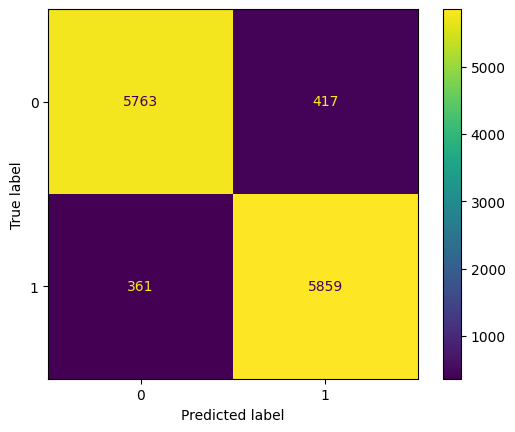

In [ ]:
# confusion metrix
cm = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()


#### Custom Data Prediction

In [ ]:
# Define custom function to make prediction based on custom data
def custom_prediction(text):
    input_encoded = tokenizer(text, return_tensors = 'pt').to(device)

    with torch.no_grad(): # disiable gradiant calculation
        output = model(**input_encoded)

    logits = output.logits # raw output
    pred = torch.argmax(logits, dim = 1).item()
    return id2label[pred]

In [ ]:
# Defining Custom data
test_data = "I did not enjoy the film Eraser whatsoever. It's awful acting, boring storyline and average special effects made this an annoying arnie film, as it had a mountain of potential. With other action films of the time Eraser fell very short!!!"

custom_prediction(test_data) # make prediction

'NEGATIVE'

#### Save the model

In [ ]:
trainer.save_model("bert_sentiment_model")
